In [134]:
#%% import

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [119]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)

In [120]:
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [122]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['Online', 'Personal Loan', 'Family', 'ID', 'Securities Account', 'Education', 'CD Account', 'CreditCard']
Intersection Columns: ['Education', 'Family']


In [123]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [124]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

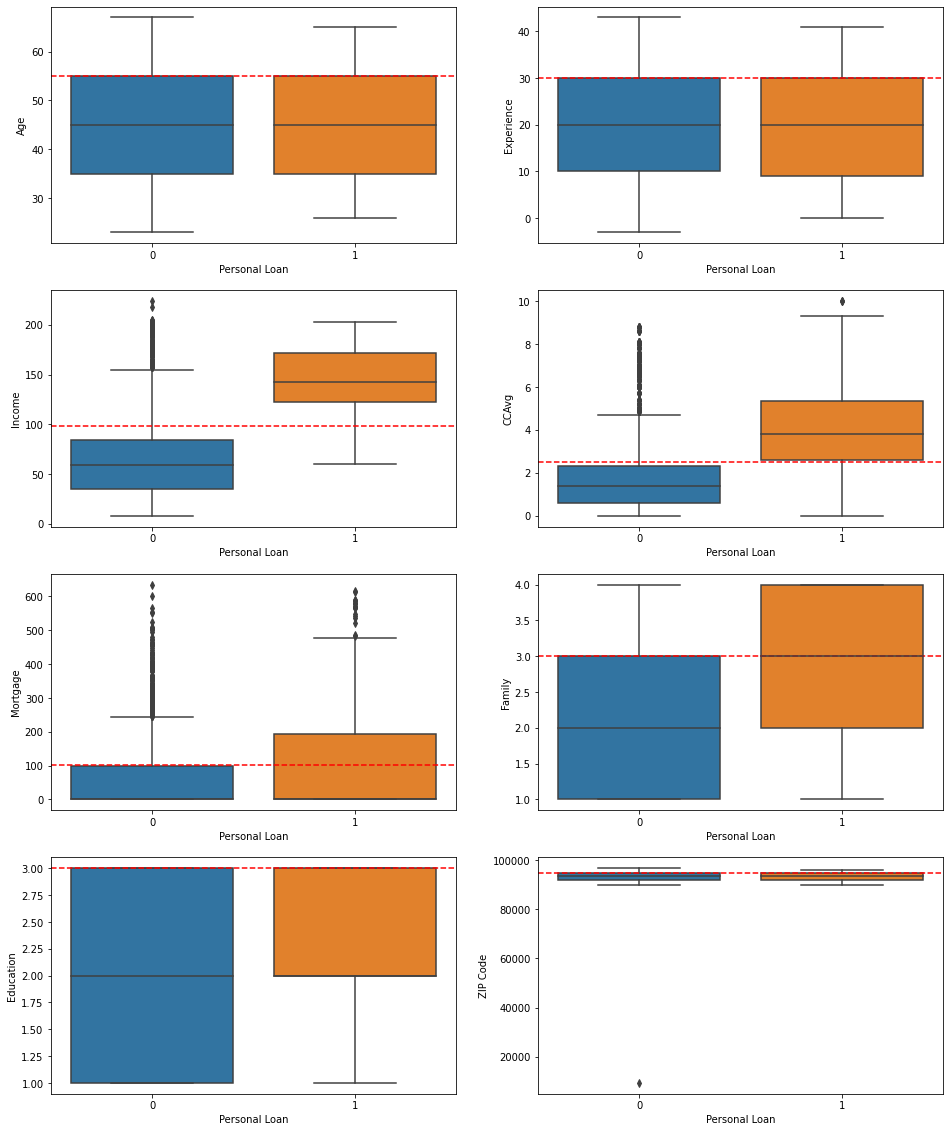

In [125]:
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')
    # axis.legend()

In [126]:
# IsSth features
df['IsMortgaged'] = df['Mortgage'] > 0
df['IsFamily'] = df['Family'] > 1
df['IsEducated'] = df['Education'] > 1

# Is > than 75 qq
df['IsMortgaged75'] = (df['Mortgage'] > df.describe().loc['75%', 'Mortgage']) & df['IsMortgaged']
df['IsIncome75'] = df['Income'] > df.describe().loc['75%', 'Income']
df['IsCCAvg75'] = df['CCAvg'] > df.describe().loc['75%', 'CCAvg']

cat_cols += ['IsMortgaged', 'HasFamily', 'IsEducated', 'IsMortgaged75', 'IsIncome75', 'IsCCAvg75']

In [127]:
def split_data(df, y_col='Personal Loan'):
    
    y = df[y_col]
    
    X, X_val, y, y_val = train_test_split(df.drop([y_col, "ID", "ZIP Code", 'Age', 'Education'], 
                                        axis=1),y, test_size=0.04,
                                        shuffle=True, random_state=19)
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2,
                                                         shuffle=True, random_state=19)
    
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)


def normalize_data(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X), (scaler.mean_, scaler.var_)


In [128]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = split_data(df)

(X_train.shape, y_train.shape),\
(X_test.shape, y_test.shape),\
(X_val.shape, y_val.shape)

(((3840, 15), (3840,)), ((960, 15), (960,)), ((200, 15), (200,)))

In [129]:
X_train, X_train_stats = normalize_data(X_train)
X_val, X_val_stats = normalize_data(X_val)
X_test, X_test_stats = normalize_data(X_test)

In [130]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.965625

In [131]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9802083333333333

In [135]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9677083333333333

In [136]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9864583333333333